# Ajustes iniciales

## Conexión a drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd ./drive/MyDrive/Colab Notebooks

/content/drive/MyDrive/Colab Notebooks


In [ ]:
%pwd

'/content/drive/MyDrive/Colab Notebooks'

## Importar los módulos *_utils

In [ ]:
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/')
from my_utils import dataset_utils
from my_utils import eval_utils
from my_utils import nn_utils
from my_utils import results_utils

In [ ]:
import pickle

# Funciones locales

## Prototipo de modelo

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout,SpatialDropout1D
from tensorflow import keras
from tensorflow.keras import layers

def convolutionalNetModel(task, params, optimizer, verbose = False):
  """
  Defines and compiles a new Keras model for a Convolutional Neural Network

  """

  SEQ_LENGTH = 55
  VEC_EMBEDDINGS_DIM = 300

  kernel_size_1, kernel_size_2, kernel_size_3 = params['kernels_combos']
  cnn_activation = params['conv_layers_activation']
  n_filters = params['n_filters']
  DL_1, DL_2 = params['dense_layers_sizes']
  spatial_dropout = params['spatial_dropout']
  dense_dropout = params['dense_dropout']

  embedding_sequences_input = keras.Input(name='INPUT', shape=(SEQ_LENGTH, VEC_EMBEDDINGS_DIM), dtype="float64")

  cnn_1 = layers.Conv1D(n_filters, kernel_size_1, activation=cnn_activation, name = 'CNN1')(embedding_sequences_input)
  cnn_1 = layers.SpatialDropout1D(spatial_dropout, name = 'SPATIAL_DROPOUT_1')(cnn_1)
  
  cnn_2 = layers.Conv1D(n_filters, kernel_size_2, activation=cnn_activation, name = 'CNN2')(embedding_sequences_input)
  cnn_2 = layers.SpatialDropout1D(spatial_dropout, name = 'SPATIAL_DROPOUT_2')(cnn_2)
  
  cnn_3 = layers.Conv1D(n_filters, kernel_size_3, activation=cnn_activation, name = 'CNN3')(embedding_sequences_input)
  cnn_3 = layers.SpatialDropout1D(spatial_dropout, name = 'SPATIAL_DROPOUT_3')(cnn_3)

  if params['pooling_method'] == 'max':
    cnn_1 = layers.GlobalMaxPooling1D(name = 'MAX_POOL_1')(cnn_1)
    cnn_2 = layers.GlobalMaxPooling1D(name = 'MAX_POOL_2')(cnn_2)
    cnn_3 = layers.GlobalMaxPooling1D(name = 'MAX_POOL_3')(cnn_3)
  elif params['pooling_method'] == 'average':
    cnn_1 = layers.GlobalAveragePooling1D(name = 'MAX_POOL_1')(cnn_1)
    cnn_2 = layers.GlobalAveragePooling1D(name = 'MAX_POOL_2')(cnn_2)
    cnn_3 = layers.GlobalAveragePooling1D(name = 'MAX_POOL_3')(cnn_3)

  fcnn = layers.Concatenate(axis=1, name = 'CONCATENATE')([cnn_1, cnn_2, cnn_3])
  fcnn = layers.Dense(DL_1, activation="relu", name = 'DL_1')(fcnn)
  fcnn = layers.Dropout(dense_dropout, name = 'DENSE_DROP_1')(fcnn)
  fcnn = layers.Dense(DL_2, activation="relu", name = 'DL_2')(fcnn)
  fcnn = layers.Dropout(dense_dropout, name = 'DENSE_DROP_2')(fcnn)

  if task in ['HS', 'TR', 'AG']:
    preds = layers.Dense(1, activation="sigmoid", name = 'PREDICTOR')(fcnn)
    model = keras.Model(embedding_sequences_input, preds)

    model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["acc"])

  elif task == 'HTA':
    preds = layers.Dense(5, activation="softmax", name = 'PREDICTOR')(fcnn)
    preds = reshape = layers.Reshape(target_shape=(5,))(preds)

    model = keras.Model(embedding_sequences_input, preds)
    model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["acc"])

  if verbose:
    model.summary()

  return model

# Combinaciones de tamaños de kernel

## Dataset

In [ ]:
X_train, Y_train = dataset_utils.loadEncodedTrainData(embedding_type='FT3',
                                                 encoding_format='EMB-SEQ',
                                                 labels_to_return=['TR'],
                                                 n_folds=7
                                                 )

FastText 3 - Spanish Unannotated Corpora
Encoding Format: EMB-SEQ

Process complete
5000 train instances retrieved

encodings_dim = (55, 300)


## Espacio de búsqueda

**Parámetros de la arquitectura**

In [ ]:
from itertools import product

from itertools import combinations
from itertools import product

candidate_kernels = [1,2,3,4,5]
kernels_combos = list(combinations(candidate_kernels, 3))

dense_layers_sizes = [(300,100),
                      (200,100)]                    

arch_params = {'kernels_combos':kernels_combos,
              'dense_layers_sizes':dense_layers_sizes,
              'n_filters':[50,100,150],
              'conv_layers_activation':['tanh'],
              'pooling_method':['max'],
              'spatial_dropout':[0.5],
              'dense_dropout':[0.5]} 

arch_params_keys = arch_params.keys()

arch_params_combos = list(product( *arch_params.values() ))          

#arch_params_combos = [params_combo for params_combo in arch_params_combos if params_combo[-2]>=params_combo[-1]]
print('{} arch_params_combos.'.format(len(arch_params_combos)))   

60 arch_params_combos.


**Parámetros de la arquitectura**

In [ ]:
trainig_params_dict = {'optimizer':['adam-1e-3', 'rmsprop-1e-3'],
                       'batch_size':[512],
                       'max_epochs':[75]}

training_params_keys = trainig_params_dict.keys()
trainig_params_combos = list(product( *trainig_params_dict.values() ))

print('\n{} trainig_params_combos.'.format(len(trainig_params_combos))) 


2 trainig_params_combos.


In [ ]:
search_space = list(product(arch_params_combos, trainig_params_combos))

print('\n{} params combinations in the search_space.'.format(len(search_space))) 


120 params combinations in the search_space.


## Escaneo

In [ ]:
results_df = nn_utils.spaceScanner(X_train, Y_train,
                          'HS',
                          convolutionalNetModel, 
                          search_space,
                          arch_params_keys,
                          training_params_keys,
                          fraction2eval=1,
                          n_folds=7,
                          fitting_attemps=1,
                          stop_threshold=1,
                          partial_CV=True,
                          backup_file='./Results/CNN/HS_kernels_experiments.df',
                          backup_freq=5,
                          save_history_files=True,
                          save_models_as_json=False)

## Resultados

In [ ]:
import pickle
from pandas import DataFrame

with open('./Results/CNN/HS_kernels_experiments.df', 'rb') as file_handler:
  search_results = pickle.load(file_handler)

search_results.shape

(120, 19)

In [ ]:
from itertools import combinations
from itertools import product

candidate_kernels = [1,2,3,4,5]
kernels_combos = list(combinations(candidate_kernels, 3))

params_dict = {'kernels_combos':kernels_combos}

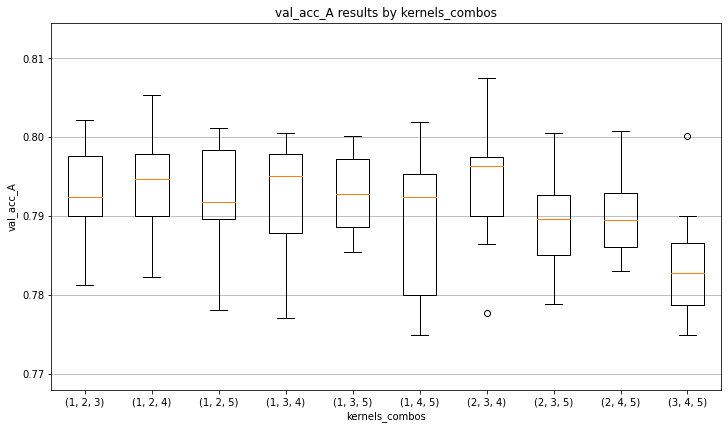

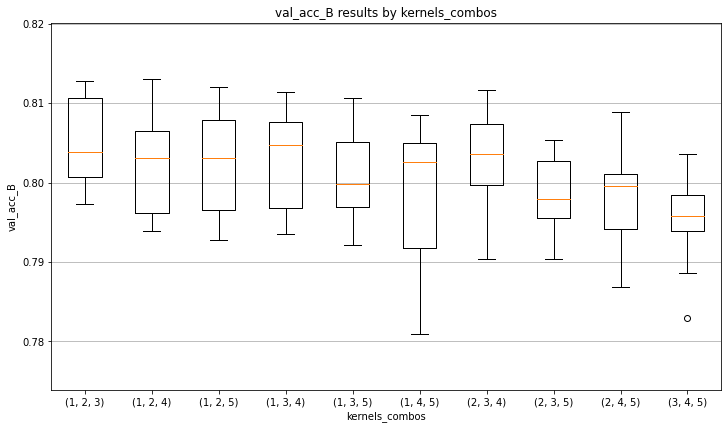

In [ ]:
results_utils.plotResultsByParameter1(search_results, 
                       params_dict, 
                       params2plot=['kernels_combos'],
                       metric='val_acc_A')

results_utils.plotResultsByParameter1(search_results, 
                       params_dict, 
                       params2plot=['kernels_combos'],
                       metric='val_acc_B')

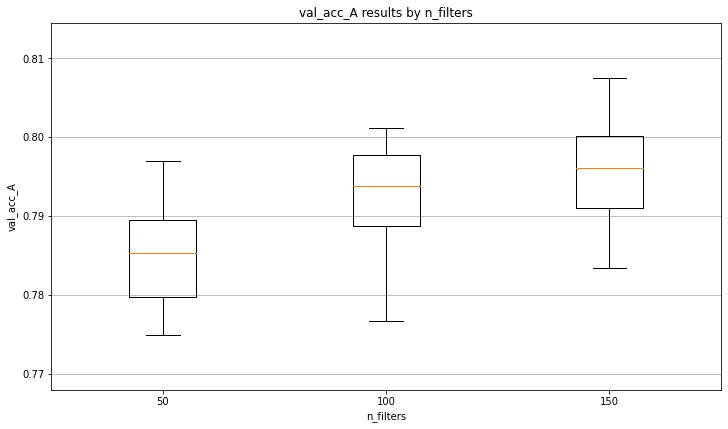

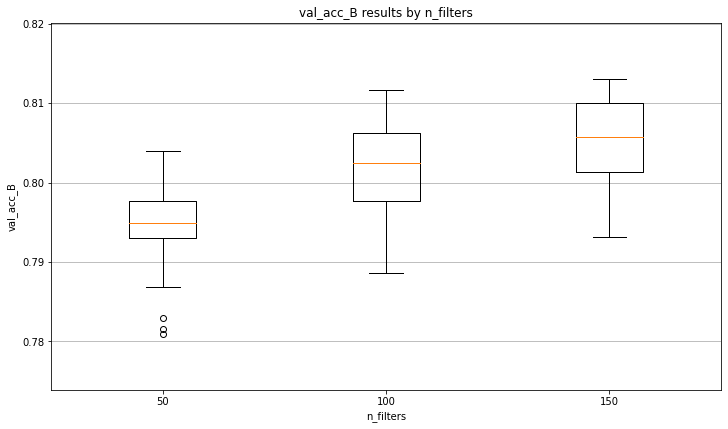

In [ ]:
params_dict = {'n_filters':[50,100,150]}

results_utils.plotResultsByParameter1(search_results, 
                       params_dict, 
                       params2plot=['n_filters'],
                       metric='val_acc_A')

results_utils.plotResultsByParameter1(search_results, 
                       params_dict, 
                       params2plot=['n_filters'],
                       metric='val_acc_B')

### Resumen de los resultados

* Mejores combinaciones de kernels sizes: (1,2,3), (2,3,4)
* lstm_units: [100,200]

# Experimentos con optimizadores

## Dataset

In [ ]:
X_train, Y_train = dataset_utils.loadEncodedTrainData(embedding_type='FT3',
                                                 encoding_format='EMB-SEQ',
                                                 labels_to_return=['HS'],
                                                 n_folds=7
                                                 )

FastText 3 - Spanish Unannotated Corpora
Encoding Format: EMB-SEQ

Process complete
5000 train instances retrieved

encodings_dim = (55, 300)


## Espacio de búsqueda

**Parámetros de la arquitectura**

In [ ]:
from itertools import product

from itertools import combinations
from itertools import product

dense_layers_sizes = [(300,100),
                      (200,100)]                    

arch_params = {'kernels_combos':[(1,2,3),(2,3,4)],
              'dense_layers_sizes':dense_layers_sizes,
              'n_filters':[100,150,200],
              'conv_layers_activation':['tanh'],
              'pooling_method':['max'],
              'spatial_dropout':[0.5],
              'dense_dropout':[0.5]} 

arch_params_keys = arch_params.keys()

arch_params_combos = list(product( *arch_params.values() ))          

#arch_params_combos = [params_combo for params_combo in arch_params_combos if params_combo[-2]>=params_combo[-1]]
print('{} arch_params_combos.'.format(len(arch_params_combos)))   

12 arch_params_combos.


**Parámetros de la arquitectura**

In [ ]:
trainig_params_dict = {'optimizer':['adam-1e-3', 'adam-5e-4', 'adam-1e-4', 'rmsprop-1e-3', 'rmsprop-5e-4', 'rmsprop-1e-4'],
                       'batch_size':[512],
                       'max_epochs':[75]}
                        

training_params_keys = trainig_params_dict.keys()
trainig_params_combos = list(product( *trainig_params_dict.values() ))

print('\n{} trainig_params_combos.'.format(len(trainig_params_combos))) 


6 trainig_params_combos.


In [ ]:
search_space = list(product(arch_params_combos, trainig_params_combos))

print('\n{} params combinations in the search_space.'.format(len(search_space))) 


72 params combinations in the search_space.


## Escaneo

In [ ]:
results_df = nn_utils.spaceScanner(X_train, Y_train,
                          'HS',
                          convolutionalNetModel, 
                          search_space,
                          arch_params_keys,
                          training_params_keys,
                          fraction2eval=1,
                          n_folds=7,
                          fitting_attemps=1,
                          stop_threshold=1,
                          partial_CV=True,
                          backup_file='./Results/CNN/HS_experiments_1.df',
                          backup_freq=5,
                          save_history_files=True,
                          save_models_as_json=False)

BackupFile: ./Results/CNN/HTA_experiments_1_batch_1.df
SCANNING SEARCH SPACE

36 configurations will be evaluated.
1  - conf_ID: xbdqfQrF   ****  --  train_acc_A = 0.813,  val_acc_A = 0.742    --  train_acc_B = 0.721,  val_acc_B = 0.757   
2  - conf_ID: VjevGVyM   

## Resultados

In [ ]:
import pickle
from pandas import DataFrame

with open('./Results/CNN/HS_experiments_1.df', 'rb') as file_handler:
  search_results = pickle.load(file_handler)

search_results.shape

(72, 18)

In [ ]:
search_results.sort_values(by='val_acc_A', ascending=False).head()

,conf_ID,kernels_combos,dense_layers_sizes,n_filters,conv_layers_activation,pooling_method,spatial_dropout,dense_dropout,batch_size,optimizer,max_epochs,best_epochh,train_acc_A,val_acc_A,min2best,max2best,train_acc_B,val_acc_B
8,GVXLmSCp,"(1, 2, 3)","(300, 100)",150,tanh,max,0.5,0.5,512,adam-1e-4,75,39,0.860875,0.814144,32,42,0.847051,0.817996
26,SKvpwzRg,"(1, 2, 3)","(200, 100)",150,tanh,max,0.5,0.5,512,adam-1e-4,75,42,0.829901,0.813094,31,48,0.819923,0.817293
25,NGKrIoqO,"(1, 2, 3)","(200, 100)",150,tanh,max,0.5,0.5,512,adam-5e-4,75,9,0.801434,0.812742,8,32,0.846171,0.818692
31,KFCAehWG,"(1, 2, 3)","(200, 100)",200,tanh,max,0.5,0.5,512,adam-5e-4,75,11,0.863734,0.810642,9,11,0.833049,0.814143
51,WEaABmFT,"(2, 3, 4)","(300, 100)",200,tanh,max,0.5,0.5,512,rmsprop-1e-3,75,22,0.838884,0.809243,13,22,0.800678,0.813445


In [ ]:
search_results.sort_values(by='val_acc_B', ascending=False).head()

,conf_ID,kernels_combos,dense_layers_sizes,n_filters,conv_layers_activation,pooling_method,spatial_dropout,dense_dropout,batch_size,optimizer,max_epochs,best_epochh,train_acc_A,val_acc_A,min2best,max2best,train_acc_B,val_acc_B
25,NGKrIoqO,"(1, 2, 3)","(200, 100)",150,tanh,max,0.5,0.5,512,adam-5e-4,75,9,0.801434,0.812742,8,32,0.846171,0.818692
8,GVXLmSCp,"(1, 2, 3)","(300, 100)",150,tanh,max,0.5,0.5,512,adam-1e-4,75,39,0.860875,0.814144,32,42,0.847051,0.817996
26,SKvpwzRg,"(1, 2, 3)","(200, 100)",150,tanh,max,0.5,0.5,512,adam-1e-4,75,42,0.829901,0.813094,31,48,0.819923,0.817293
69,oPXXqxfE,"(2, 3, 4)","(200, 100)",200,tanh,max,0.5,0.5,512,rmsprop-1e-3,75,24,0.869625,0.807840,17,26,0.832291,0.817292
50,ljPktBlA,"(2, 3, 4)","(300, 100)",200,tanh,max,0.5,0.5,512,adam-1e-4,75,26,0.863091,0.805743,25,29,0.881583,0.815545


In [ ]:
params_dict = {'optimizer':['adam-1e-3', 'adam-5e-4', 'adam-1e-4', 
                            'rmsprop-1e-3', 'rmsprop-5e-4', 'rmsprop-1e-4']}

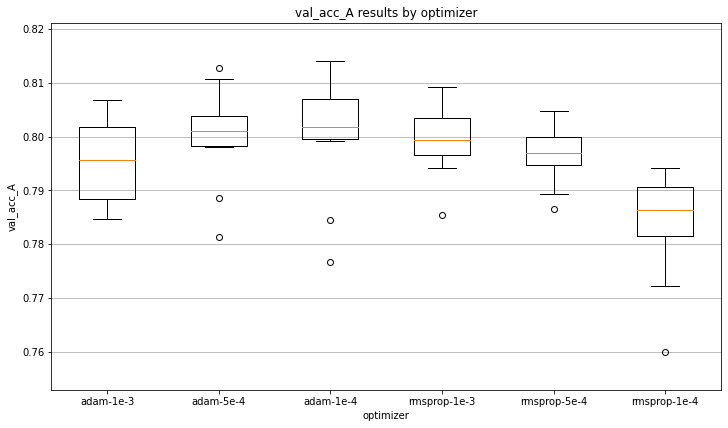

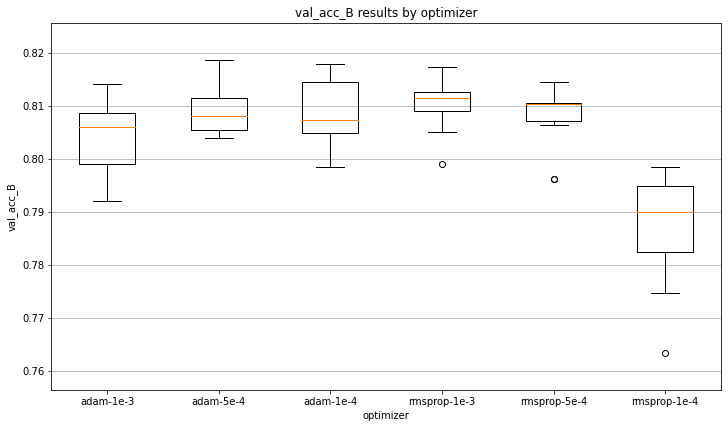

In [ ]:
results_utils.plotResultsByParameter1(search_results, 
                       params_dict, 
                       params2plot=['optimizer'],
                       metric='val_acc_A')

results_utils.plotResultsByParameter1(search_results, 
                       params_dict, 
                       params2plot=['optimizer'],
                       metric='val_acc_B')

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


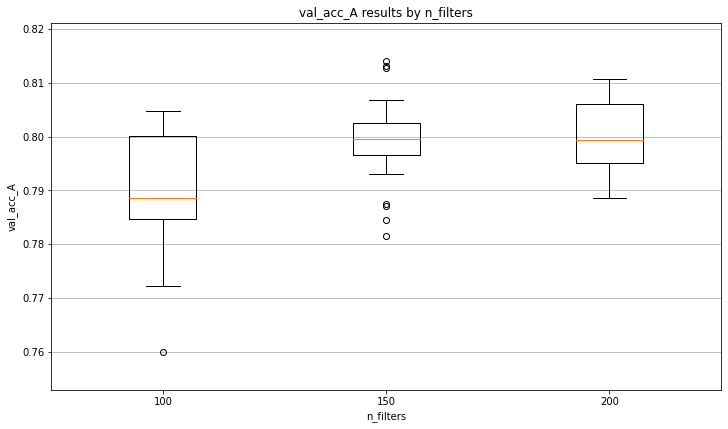

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


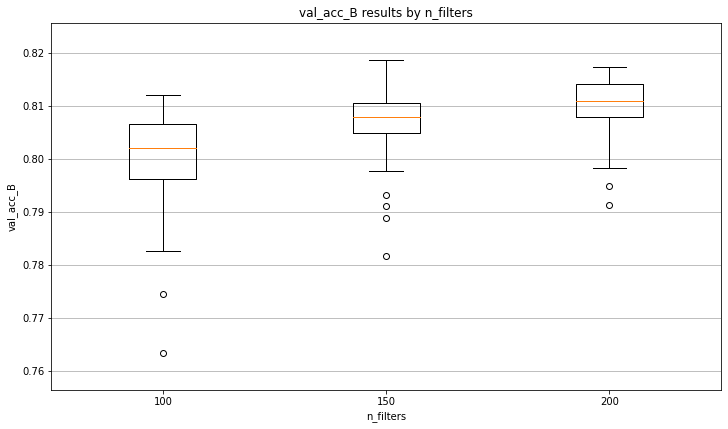

In [ ]:
params_dict = {'n_filters':[100,150,200]}

results_utils.plotResultsByParameter1(search_results, 
                       params_dict, 
                       params2plot=['n_filters'],
                       metric='val_acc_A')

results_utils.plotResultsByParameter1(search_results, 
                       params_dict, 
                       params2plot=['n_filters'],
                       metric='val_acc_B')

### Resumen de los resultados

* Mejores combinaciones de kernels sizes: (1,2,3), (2,3,4)
* lstm_units: [150,200]
* Optimizador: 'adam-1e-4', 'rmsprop-1e-3'

# Experimentos con el tamaño de las capas densas

## Dataset

In [ ]:
X_train, Y_train = dataset_utils.loadEncodedTrainData(embedding_type='FT3',
                                                 encoding_format='EMB-SEQ',
                                                 labels_to_return=['TR'],
                                                 n_folds=7
                                                 )

FastText 3 - Spanish Unannotated Corpora
Encoding Format: EMB-SEQ

Process complete
5000 train instances retrieved

encodings_dim = (55, 300)


## Espacio de búsqueda

**Parámetros de la arquitectura**

In [ ]:
from itertools import product

from itertools import combinations
from itertools import product

dense_layers_sizes = [(400,100),
                      (400,75), 
                      (300,100),
                      (300,75),
                      (200,100),
                      (200,75)]                    

arch_params = {'kernels_combos':[(1,2,3),(2,3,4)],
              'dense_layers_sizes':dense_layers_sizes,
              'n_filters':[150,200],
              'conv_layers_activation':['tanh'],
              'pooling_method':['max'],
              'spatial_dropout':[0.5],
              'dense_dropout':[0.5]} 

arch_params_keys = arch_params.keys()

arch_params_combos = list(product( *arch_params.values() ))          

#arch_params_combos = [params_combo for params_combo in arch_params_combos if params_combo[-2]>=params_combo[-1]]
print('{} arch_params_combos.'.format(len(arch_params_combos)))   

24 arch_params_combos.


**Parámetros de la arquitectura**

In [ ]:
trainig_params_dict = {'optimizer':['adam-1e-4', 'rmsprop-1e-3'],
                       'batch_size':[512],
                       'max_epochs':[75]}
                        

training_params_keys = trainig_params_dict.keys()
trainig_params_combos = list(product( *trainig_params_dict.values() ))

print('\n{} trainig_params_combos.'.format(len(trainig_params_combos))) 


2 trainig_params_combos.


In [ ]:
search_space = list(product(arch_params_combos, trainig_params_combos))

print('\n{} params combinations in the search_space.'.format(len(search_space))) 


48 params combinations in the search_space.


## Escaneo

In [ ]:
results_df = nn_utils.spaceScanner(X_train, Y_train,
                          'TR',
                          convolutionalNetModel, 
                          search_space,
                          arch_params_keys,
                          training_params_keys,
                          fraction2eval=1,
                          n_folds=7,
                          fitting_attemps=1,
                          stop_threshold=1,
                          partial_CV=True,
                          backup_file='./Results/CNN/TR/experiments_2.df',
                          backup_freq=5,
                          save_history_files=True,
                          save_models_as_json=False)

BackupFile: ./Results/CNN/TR/experiments_2.df
SCANNING SEARCH SPACE

48 configurations will be evaluated.
1  - conf_ID: gwlvFiVp   ****  --  train_acc_1 = 0.891,  val_acc_1 = 0.888    --  train_acc_2 = 0.872,  val_acc_2 = 0.9     
2  - conf_ID: ADTVbcEi   ****  --  train_acc_1 = 0.84,   val_acc_1 = 0.892    --  train_acc_2 = 0.85,   val_acc_2 = 0.902   
3  - conf_ID: fUPvFphQ   ****  --  train_acc_1 = 0.87,   val_acc_1 = 0.897    --  train_acc_2 = 0.894,  val_acc_2 = 0.901   
4  - conf_ID: MAVsVStF   ****  --  train_acc_1 = 0.858,  val_acc_1 = 0.9      --  train_acc_2 = 0.859,  val_acc_2 = 0.901   
5  - conf_ID: FlXoHJkz   ****  --  train_acc_1 = 0.866,  val_acc_1 = 0.894    --  train_acc_2 = 0.876,  val_acc_2 = 0.897   
6  - conf_ID: YteYUpSe   ****  --  train_acc_1 = 0.87,   val_acc_1 = 0.889    --  train_acc_2 = 0.843,  val_acc_2 = 0.895   
7  - conf_ID: ZdKahMjW   ****  --  train_acc_1 = 0.902,  val_acc_1 = 0.897    --  train_acc_2 = 0.894,  val_acc_2 = 0.902   
8  - conf_ID: lyNbI

## Resultados

In [ ]:
import pickle
from pandas import DataFrame

with open('./Results/CNN/TR/experiments_2.df', 'rb') as file_handler:
  search_results = pickle.load(file_handler)

search_results.shape

(48, 19)

In [ ]:
search_results.sort_values(by='val_acc_A', ascending=False).head()

In [ ]:
search_results.sort_values(by='val_acc_B', ascending=False).head()

In [ ]:
params_dict = {'dense_layers_sizes':[(400,100),
                      (400,75), 
                      (300,100),
                      (300,75),
                      (200,100),
                      (200,75)]}

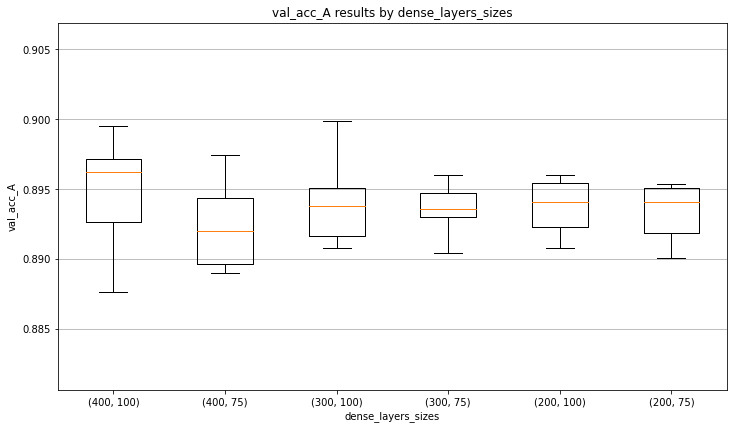

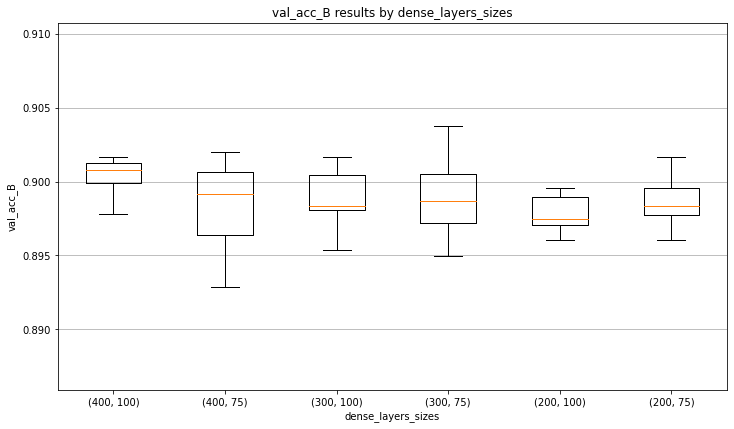

In [ ]:
results_utils.plotResultsByParameter1(search_results, 
                       params_dict, 
                       params2plot=['dense_layers_sizes'],
                       metric='val_acc_A')

results_utils.plotResultsByParameter1(search_results, 
                       params_dict, 
                       params2plot=['dense_layers_sizes'],
                       metric='val_acc_B')

### Resumen de los resultados

* Mejores combinaciones de kernels sizes: (1,2,3), (2,3,4)
* lstm_units: [150,200]
* dense_layers_sizes: [(300,100),**(200,75)**], [**(400,75)**,(200,100)]
* Optimizador: 'adam-1e-4', 'rmsprop-1e-3'

# Experimentos con los valores de dropout

In [ ]:
X_train, Y_train = dataset_utils.loadEncodedTrainData(embedding_type='FT3',
                                                 encoding_format='EMB-SEQ',
                                                 labels_to_return=['TR'],
                                                 n_folds=7
                                                 )

## Espacio de búsqueda

**Parámetros de la arquitectura**

In [ ]:
from itertools import product

from itertools import combinations
from itertools import product

dense_layers_sizes = [(400,100)]                    

arch_params = {'kernels_combos':[(1,2,3),(2,3,4)],
              'dense_layers_sizes':dense_layers_sizes,
              'n_filters':[175],
              'conv_layers_activation':['tanh'],
              'pooling_method':['max'],
              'spatial_dropout':[0.3,0.5,0.7],
              'dense_dropout':[0.3,0.5,0.7]} 

arch_params_keys = arch_params.keys()

arch_params_combos = list(product( *arch_params.values() ))          

#arch_params_combos = [params_combo for params_combo in arch_params_combos if params_combo[-2]>=params_combo[-1]]
print('{} arch_params_combos.'.format(len(arch_params_combos)))   

18 arch_params_combos.


**Parámetros de la arquitectura**

In [ ]:
trainig_params_dict = {'optimizer':['adam-1e-4', 'rmsprop-1e-3'],
                       'batch_size':[512],
                       'max_epochs':[75]}
                        

training_params_keys = trainig_params_dict.keys()
trainig_params_combos = list(product( *trainig_params_dict.values() ))

print('\n{} trainig_params_combos.'.format(len(trainig_params_combos))) 


2 trainig_params_combos.


In [ ]:
search_space = list(product(arch_params_combos, trainig_params_combos))

print('\n{} params combinations in the search_space.'.format(len(search_space))) 


36 params combinations in the search_space.


## Escaneo

In [ ]:
results_df = nn_utils.spaceScanner(X_train, Y_train,
                          'TR',
                          convolutionalNetModel, 
                          search_space,
                          arch_params_keys,
                          training_params_keys,
                          fraction2eval=1,
                          n_folds=7,
                          fitting_attemps=1,
                          stop_threshold=1,
                          partial_CV=True,
                          backup_file='./Results/CNN/TR/experiments_3.df',
                          backup_freq=5,
                          save_history_files=True,
                          save_models_as_json=False)

## Resultados

In [ ]:
import pickle
from pandas import DataFrame

with open('./Results/CNN/TR/experiments_3.df', 'rb') as file_handler:
  search_results = pickle.load(file_handler)

search_results.shape

(36, 19)

In [ ]:
search_results.sort_values(by='val_acc_A', ascending=False).head(10)

In [ ]:
search_results.sort_values(by='val_acc_B', ascending=False).head(10)

In [ ]:
params_dict = {'spatial_dropout':[0.3,0.5,0.7]}

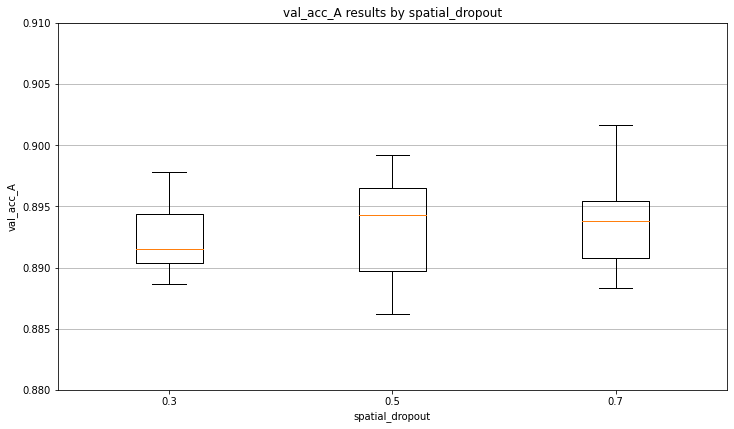

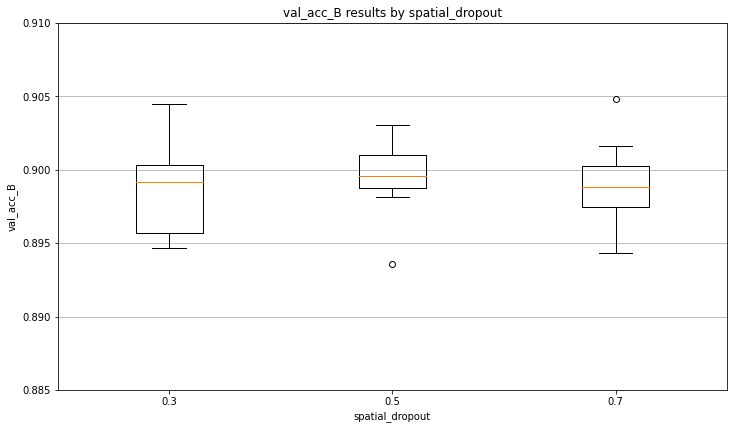

In [ ]:
results_utils.plotResultsByParameter1(search_results, 
                       params_dict, 
                       params2plot=['spatial_dropout'],
                       metric='val_acc_A',
                       y_limits=[0.88,0.91])

results_utils.plotResultsByParameter1(search_results, 
                       params_dict, 
                       params2plot=['spatial_dropout'],
                       metric='val_acc_B',
                       y_limits=[0.885,0.91])

In [ ]:
params_dict = {'dense_dropout':[0.3,0.5,0.7]}
spatial_dropout_mask = search_results['spatial_dropout'].isin([0.5])

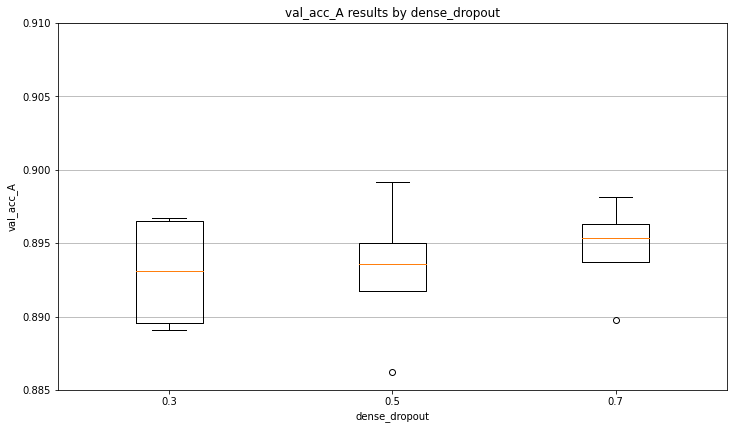

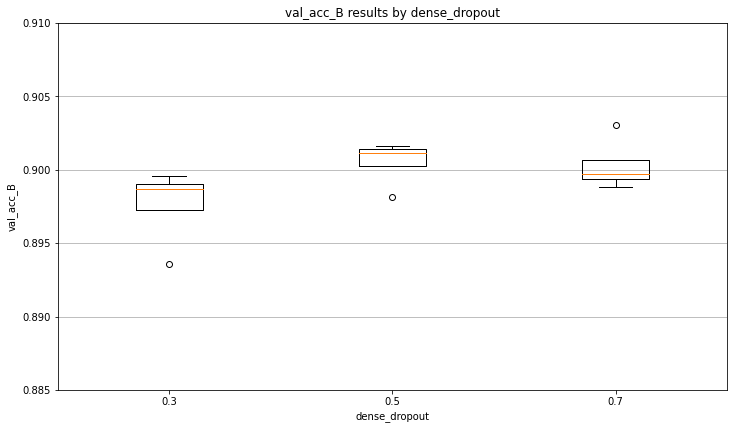

In [ ]:
results_utils.plotResultsByParameter1(search_results.loc[spatial_dropout_mask], 
                       params_dict, 
                       params2plot=['dense_dropout'],
                       metric='val_acc_A',
                       y_limits=[0.885,0.91])

results_utils.plotResultsByParameter1(search_results.loc[spatial_dropout_mask], 
                       params_dict, 
                       params2plot=['dense_dropout'],
                       metric='val_acc_B',
                       y_limits=[0.885,0.91])

### Resumen de los resultados

* Mejores combinaciones de kernels sizes: (1,2,3), (2,3,4)
* lstm_units: [150,200]
* dense_layers_sizes: [(300,100),**(200,75)**], [**(400,75)**,(200,100)]
* spatial_dropout: [0.3,**0.5**]
* dense_dropout:[**0.5**]


* Optimizador: 'adam-1e-4', 'rmsprop-1e-3'


# Experimentos con la función de activación y pooling method

## Dataset

In [ ]:
X_train, Y_train = dataset_utils.loadEncodedTrainData(embedding_type='FT3',
                                                 encoding_format='EMB-SEQ',
                                                 labels_to_return=['TR'],
                                                 n_folds=7
                                                 )

FastText 3 - Spanish Unannotated Corpora
Encoding Format: EMB-SEQ

Process complete
5000 train instances retrieved

encodings_dim = (55, 300)


## Espacio de búsqueda

**Parámetros de la arquitectura**

In [ ]:
from itertools import combinations
from itertools import product

dense_layers_sizes = [(400,100)]                    

arch_params = {'kernels_combos':[(1,2,3),(2,3,4)],
              'dense_layers_sizes':dense_layers_sizes,
              'n_filters':[175, 200],
              'conv_layers_activation':['tanh','relu'],
              'pooling_method':['max', 'average'],
              'spatial_dropout':[0.5],
              'dense_dropout':[0.5]} 

arch_params_keys = arch_params.keys()

arch_params_combos = list(product( *arch_params.values() ))          

#arch_params_combos = [params_combo for params_combo in arch_params_combos if params_combo[-2]>=params_combo[-1]]
print('{} arch_params_combos.'.format(len(arch_params_combos)))     

16 arch_params_combos.


**Parámetros de la arquitectura**

In [ ]:
trainig_params_dict = {'optimizer':['adam-1e-4', 'rmsprop-1e-3'],
                       'batch_size':[512],
                       'max_epochs':[75]}
                        

training_params_keys = trainig_params_dict.keys()
trainig_params_combos = list(product( *trainig_params_dict.values() ))

print('\n{} trainig_params_combos.'.format(len(trainig_params_combos))) 


2 trainig_params_combos.


In [ ]:
search_space = list(product(arch_params_combos, trainig_params_combos))

print('\n{} params combinations in the search_space.'.format(len(search_space))) 


32 params combinations in the search_space.


## Escaneo

In [ ]:
results_df = nn_utils.spaceScanner(X_train, Y_train,
                          'TR',
                          convolutionalNetModel, 
                          search_space,
                          arch_params_keys,
                          training_params_keys,
                          fraction2eval=1,
                          n_folds=7,
                          fitting_attemps=1,
                          stop_threshold=1,
                          partial_CV=True,
                          backup_file='./Results/CNN/TR/experiments_4.df',
                          backup_freq=5,
                          save_history_files=True,
                          save_models_as_json=False)

BackupFile: ./Results/CNN/TR/experiments_4.df
SCANNING SEARCH SPACE

32 configurations will be evaluated.
1  - conf_ID: NcDJzlBO   ****  --  train_acc_1 = 0.896,  val_acc_1 = 0.885    --  train_acc_2 = 0.864,  val_acc_2 = 0.896   
2  - conf_ID: MwEjvDfW   ****  --  train_acc_1 = 0.872,  val_acc_1 = 0.89     --  train_acc_2 = 0.876,  val_acc_2 = 0.903   
3  - conf_ID: aqIjJcvy   ****  --  train_acc_1 = 0.822,  val_acc_1 = 0.87     --  train_acc_2 = 0.82,   val_acc_2 = 0.873   
4  - conf_ID: jfWOaCDd   ****  --  train_acc_1 = 0.828,  val_acc_1 = 0.862    --  train_acc_2 = 0.825,  val_acc_2 = 0.871   
5  - conf_ID: SWfOfNFH   ****  --  train_acc_1 = 0.865,  val_acc_1 = 0.898    --  train_acc_2 = 0.867,  val_acc_2 = 0.901   
6  - conf_ID: ECXraioU   ****  --  train_acc_1 = 0.858,  val_acc_1 = 0.893    --  train_acc_2 = 0.849,  val_acc_2 = 0.902   
7  - conf_ID: qFrPUeey   ****  --  train_acc_1 = 0.889,  val_acc_1 = 0.89     --  train_acc_2 = 0.895,  val_acc_2 = 0.893   
8  - conf_ID: EGLjI

## Resultados

In [ ]:
results_list = ['./Results/CNN/HS_experiments_4_batch_1.df',
                './Results/CNN/HS_experiments_4_batch_2.df',
                './Results/CNN/HS_experiments_4_batch_3.df',
                './Results/CNN/HS_experiments_4_batch_4.df']

results_df = results_utils.mergeDataFrames(results_list, './Results/CNN/HS_experiments_4.df')

In [ ]:
import pickle
from pandas import DataFrame

with open('./Results/CNN/TR/experiments_4.df', 'rb') as file_handler:
  search_results = pickle.load(file_handler)

search_results.shape

(32, 19)

In [ ]:
search_results.sort_values(by='val_acc_A', ascending=False).head(10)

In [ ]:
search_results.sort_values(by='val_acc_B', ascending=False).head(10)

In [ ]:
params_dict = {'conv_layers_activation':['tanh', 'relu']}

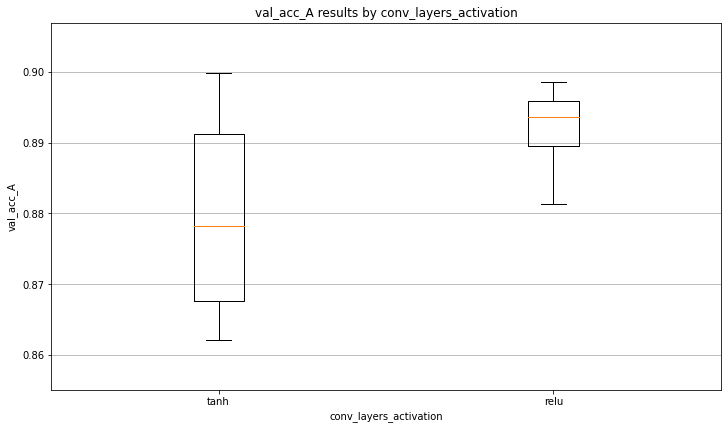

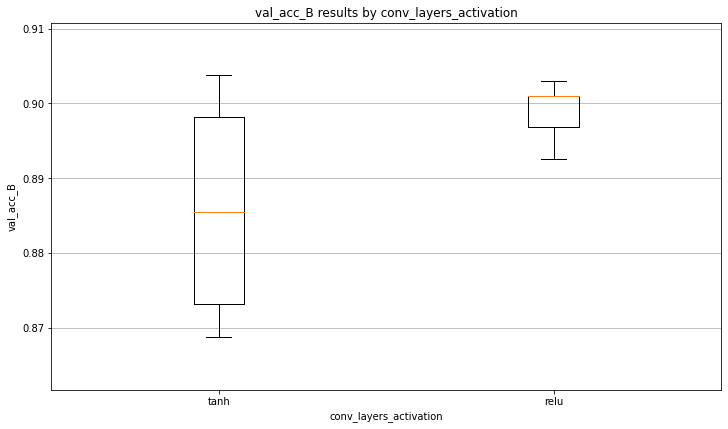

In [ ]:
results_utils.plotResultsByParameter1(search_results, 
                       params_dict, 
                       params2plot=['conv_layers_activation'],
                       metric='val_acc_A')

results_utils.plotResultsByParameter1(search_results, 
                       params_dict, 
                       params2plot=['conv_layers_activation'],
                       metric='val_acc_B')

In [ ]:
params_dict = {'pooling_method':['max', 'average']}

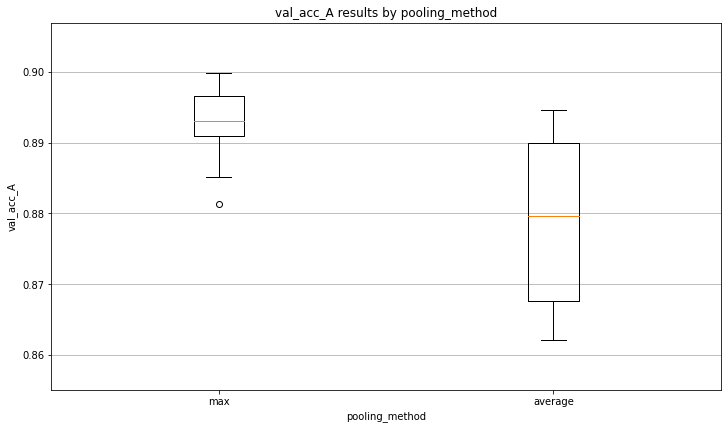

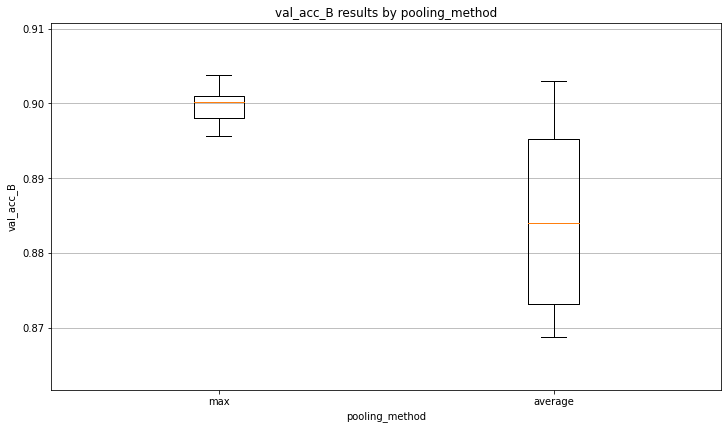

In [ ]:
results_utils.plotResultsByParameter1(search_results, 
                       params_dict, 
                       params2plot=['pooling_method'],
                       metric='val_acc_A')

results_utils.plotResultsByParameter1(search_results, 
                       params_dict, 
                       params2plot=['pooling_method'],
                       metric='val_acc_B')

In [ ]:
params_dict = {'n_filters':[175, 200]}

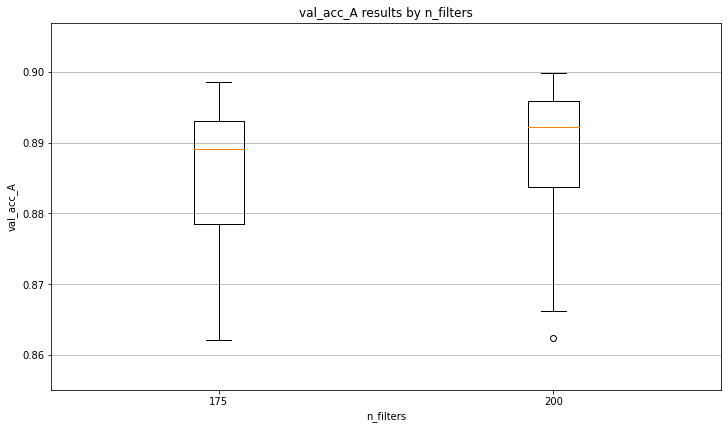

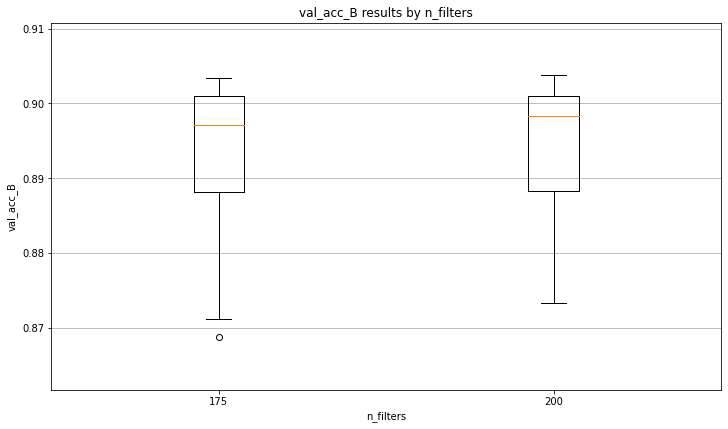

In [ ]:
results_utils.plotResultsByParameter1(search_results, 
                       params_dict, 
                       params2plot=['n_filters'],
                       metric='val_acc_A')

results_utils.plotResultsByParameter1(search_results, 
                       params_dict, 
                       params2plot=['n_filters'],
                       metric='val_acc_B')

### Resumen de los resultados

* Mejores combinaciones de kernels sizes: (1,2,3), (2,3,4)
* lstm_units: [150,200]
* dense_layers_sizes: [(300,100),**(200,75)**], [**(400,75)**,(200,100)]
* cnn_activation: ['tanh', **'relu'**]
* pooling_method: 'max'
* spatial_dropout: [0.3,**0.5**]
* dense_dropout:[**0.5**]


* Optimizador: 'adam-1e-4', 'rmsprop-1e-3'

# Experimentos con el batch_size

## Dataset

In [ ]:
X_train, Y_train = dataset_utils.loadEncodedTrainData(embedding_type='FT3',
                                                 encoding_format='EMB-SEQ',
                                                 labels_to_return=['TR'],
                                                 n_folds=7
                                                 )

FastText 3 - Spanish Unannotated Corpora
Encoding Format: EMB-SEQ

Process complete
5000 train instances retrieved

encodings_dim = (55, 300)


## Espacio de búsqueda

**Parámetros de la arquitectura**

In [ ]:
from itertools import combinations
from itertools import product

dense_layers_sizes = [(400,100)]                    

arch_params = {'kernels_combos':[(1,2,3),(2,3,4)],
              'dense_layers_sizes':dense_layers_sizes,
              'n_filters':[175, 200],
              'conv_layers_activation':['relu'],
              'pooling_method':['max'],
              'spatial_dropout':[0.5],
              'dense_dropout':[0.5]} 

arch_params_keys = arch_params.keys()

arch_params_combos = list(product( *arch_params.values() ))          

#arch_params_combos = [params_combo for params_combo in arch_params_combos if params_combo[-2]>=params_combo[-1]]
print('{} arch_params_combos.'.format(len(arch_params_combos)))   

4 arch_params_combos.


**Parámetros de la arquitectura**

In [ ]:
trainig_params_dict = {'optimizer':['adam-1e-4', 'rmsprop-1e-3'],
                       'batch_size':[256,512,1024],
                       'max_epochs':[75]}
                        

training_params_keys = trainig_params_dict.keys()
trainig_params_combos = list(product( *trainig_params_dict.values() ))

print('\n{} trainig_params_combos.'.format(len(trainig_params_combos))) 


6 trainig_params_combos.


In [ ]:
search_space = list(product(arch_params_combos, trainig_params_combos))

print('\n{} params combinations in the search_space.'.format(len(search_space))) 


24 params combinations in the search_space.


## Escaneo

In [ ]:
results_df = nn_utils.spaceScanner(X_train, Y_train,
                          'TR',
                          convolutionalNetModel, 
                          search_space,
                          arch_params_keys,
                          training_params_keys,
                          fraction2eval=1,
                          n_folds=7,
                          fitting_attemps=1,
                          stop_threshold=1,
                          partial_CV=True,
                          backup_file='./Results/CNN/TR/experiments_5.df',
                          backup_freq=5,
                          save_history_files=True,
                          save_models_as_json=False)

BackupFile: ./Results/CNN/TR/experiments_5.df
SCANNING SEARCH SPACE

24 configurations will be evaluated.
1  - conf_ID: LVLhjiNa   ****  --  train_acc_1 = 0.842,  val_acc_1 = 0.898    --  train_acc_2 = 0.85,   val_acc_2 = 0.902   
2  - conf_ID: IhPrGmDl   ****  --  train_acc_1 = 0.907,  val_acc_1 = 0.893    --  train_acc_2 = 0.864,  val_acc_2 = 0.897   
3  - conf_ID: ZTJXdNRA   ****  --  train_acc_1 = 0.9,    val_acc_1 = 0.897    --  train_acc_2 = 0.866,  val_acc_2 = 0.901   
4  - conf_ID: pRjjeEgr   ****  --  train_acc_1 = 0.869,  val_acc_1 = 0.89     --  train_acc_2 = 0.865,  val_acc_2 = 0.897   
5  - conf_ID: PutfgsTI   ****  --  train_acc_1 = 0.909,  val_acc_1 = 0.885    --  train_acc_2 = 0.86,   val_acc_2 = 0.9     
6  - conf_ID: yqLhBzvT   ****  --  train_acc_1 = 0.865,  val_acc_1 = 0.891    --  train_acc_2 = 0.836,  val_acc_2 = 0.9     
7  - conf_ID: yEdUodTK   ****  --  train_acc_1 = 0.889,  val_acc_1 = 0.895    --  train_acc_2 = 0.89,   val_acc_2 = 0.9     
8  - conf_ID: ePJPS

## Resultados

In [ ]:
results_list = ['./Results/CNN/HS_experiments_5_batch_1.df',
                './Results/CNN/HS_experiments_5_batch_2.df',
                './Results/CNN/HS_experiments_5_batch_3.df']

results_df = results_utils.mergeDataFrames(results_list, './Results/CNN/HS_experiments_5.df')

In [ ]:
import pickle
from pandas import DataFrame

with open('./Results/CNN/TR/experiments_5.df', 'rb') as file_handler:
  search_results = pickle.load(file_handler)

search_results.shape

(24, 19)

In [ ]:
search_results.sort_values(by='val_acc_A', ascending=False).head(10)

In [ ]:
search_results.sort_values(by='val_acc_B', ascending=False).head(10)

In [ ]:
params_dict = {'batch_size':[256,512,1024]}

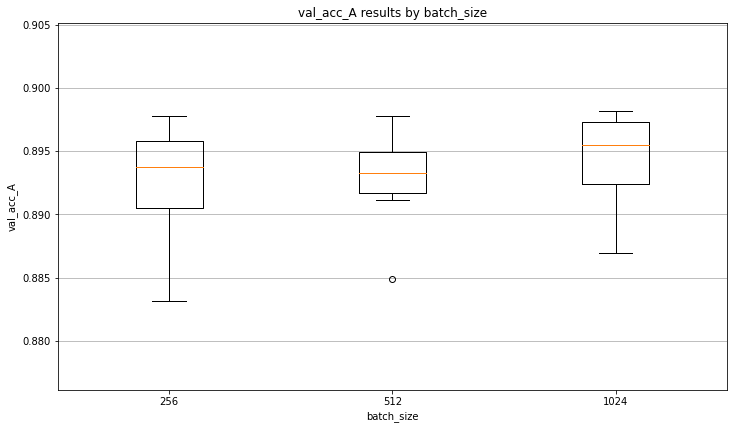

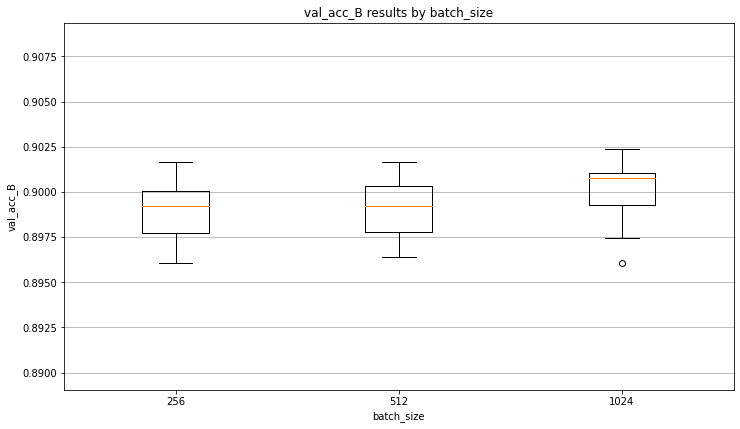

In [ ]:
results_utils.plotResultsByParameter1(search_results, 
                       params_dict, 
                       params2plot=['batch_size'],
                       metric='val_acc_A')

results_utils.plotResultsByParameter1(search_results, 
                       params_dict, 
                       params2plot=['batch_size'],
                       metric='val_acc_B')

In [ ]:
params_dict = {'n_filters':[175,200]}

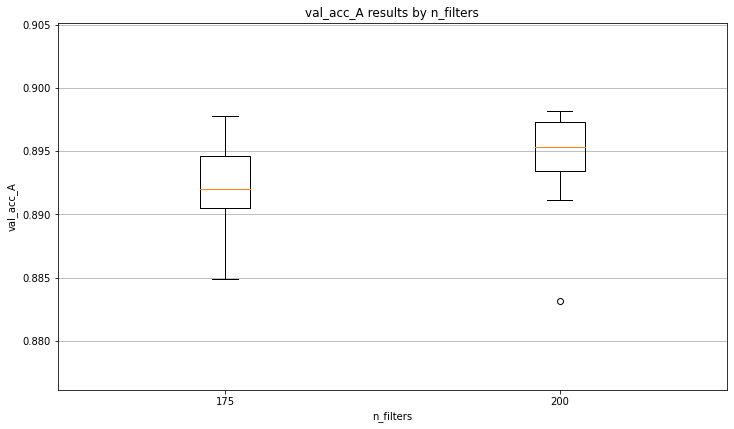

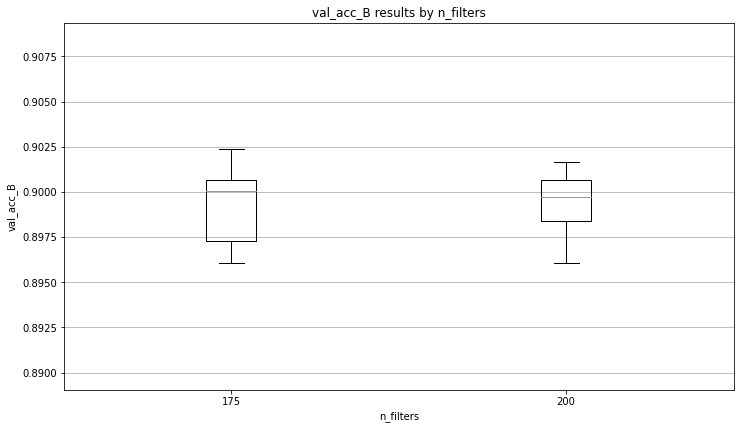

In [ ]:
results_utils.plotResultsByParameter1(search_results, 
                       params_dict, 
                       params2plot=['n_filters'],
                       metric='val_acc_A')

results_utils.plotResultsByParameter1(search_results, 
                       params_dict, 
                       params2plot=['n_filters'],
                       metric='val_acc_B')

### Resumen de los resultados

* Mejores combinaciones de kernels sizes: (1,2,3), (2,3,4)
* lstm_units: [150,200]
* dense_layers_sizes: [(300,100),**(200,75)**], [**(400,75)**,(200,100)]
* cnn_activation: ['tanh', **'relu'**]
* pooling_method: 'max'
* spatial_dropout: [0.3,**0.5**]
* dense_dropout:[**0.5**]


* Optimizador: 'adam-1e-4', 'rmsprop-1e-3'
* batch_size: [256,**1024**]

# Experimento final

## Dataset

In [ ]:
X_train, Y_train = dataset_utils.loadEncodedTrainData(embedding_type='FT3',
                                                 encoding_format='EMB-SEQ',
                                                 labels_to_return=['HTA'],
                                                 n_folds=7
                                                 )

FastText 3 - Spanish Unannotated Corpora
Encoding Format: EMB-SEQ

Process complete
5000 train instances retrieved

encodings_dim = (55, 300)


## Espacio de búsqueda

**Parámetros de la arquitectura**

In [ ]:
from itertools import combinations
from itertools import product

dense_layers_sizes = [(400,100)]                     

arch_params = {'kernels_combos':[(1,2,3),(2,3,4)],
              'dense_layers_sizes':dense_layers_sizes,
              'n_filters':[175, 200],
              'conv_layers_activation':['relu'],
              'pooling_method':['max'],
              'spatial_dropout':[0.5],
              'dense_dropout':[0.5]} 

arch_params_keys = arch_params.keys()

arch_params_combos = list(product( *arch_params.values() ))          

#arch_params_combos = [params_combo for params_combo in arch_params_combos if params_combo[-2]>=params_combo[-1]]
print('{} arch_params_combos.'.format(len(arch_params_combos)))   

4 arch_params_combos.


**Parámetros de la arquitectura**

In [ ]:
trainig_params_dict = {'optimizer':['adam-1e-4', 'rmsprop-1e-3'],
                       'batch_size':[1024],
                       'max_epochs':[75]}
                        

training_params_keys = trainig_params_dict.keys()
trainig_params_combos = list(product( *trainig_params_dict.values() ))

print('\n{} trainig_params_combos.'.format(len(trainig_params_combos))) 


2 trainig_params_combos.


In [ ]:
search_space = list(product(arch_params_combos, trainig_params_combos))

print('\n{} params combinations in the search_space.'.format(len(search_space))) 


8 params combinations in the search_space.


## Escaneo

In [ ]:
results_df = nn_utils.spaceScanner(X_train, Y_train,
                          'TR',
                          convolutionalNetModel, 
                          search_space,
                          arch_params_keys,
                          training_params_keys,
                          fraction2eval=1,
                          n_folds=7,
                          fitting_attemps=1,
                          stop_threshold=1,
                          partial_CV=False,
                          backup_file='./Results/CNN/TR/experiments_6.df',
                          backup_freq=1,
                          save_history_files=True,
                          save_models_as_json=True,
                          save_weights=True)


BackupFile: ./Results/CNN/TR/experiments_6.df
SCANNING SEARCH SPACE

8 configurations will be evaluated.
1 - conf_ID: TfFFXlkd   *******  --  train_acc_1 = 0.885,  val_acc_1 = 0.897    --  train_acc_2 = 0.873,  val_acc_2 = 0.899   
2 - conf_ID: oRGmNoZx   *******  --  train_acc_1 = 0.886,  val_acc_1 = 0.893    --  train_acc_2 = 0.847,  val_acc_2 = 0.903   
3 - conf_ID: sWquCUHY   *******  --  train_acc_1 = 0.863,  val_acc_1 = 0.894    --  train_acc_2 = 0.887,  val_acc_2 = 0.899   
4 - conf_ID: oziyYwlg   *******  --  train_acc_1 = 0.909,  val_acc_1 = 0.89     --  train_acc_2 = 0.85,   val_acc_2 = 0.903   
5 - conf_ID: XKWyJjCp   *******  --  train_acc_1 = 0.915,  val_acc_1 = 0.895    --  train_acc_2 = 0.885,  val_acc_2 = 0.9     
6 - conf_ID: pTXwsqCt   *******  --  train_acc_1 = 0.899,  val_acc_1 = 0.894    --  train_acc_2 = 0.885,  val_acc_2 = 0.903   
7 - conf_ID: wrfidhVN   *******  --  train_acc_1 = 0.862,  val_acc_1 = 0.896    --  train_acc_2 = 0.883,  val_acc_2 = 0.901   
8 - co

## Resultados

In [ ]:
results_list = ['./Results/CNN/HS_experiments_6f_batch_1.df',
                './Results/CNN/HS_experiments_6f_batch_2.df',
                './Results/CNN/HS_experiments_6f_batch_3.df',
                './Results/CNN/HS_experiments_6f_batch_4.df',
                './Results/CNN/HS_experiments_6f_batch_5.df',
                './Results/CNN/HS_experiments_6f_batch_6.df']

results_df = results_utils.mergeDataFrames(results_list, './Results/CNN/HS_experiments_6f.df')

In [ ]:
import pickle
from pandas import DataFrame

with open('./Results/CNN/TR/experiments_6.df', 'rb') as file_handler:
  search_results = pickle.load(file_handler)

search_results.shape

(8, 19)

In [ ]:
search_results.sort_values(by='val_acc_A', ascending=False).head()

,conf_ID,kernels_combos,dense_layers_sizes,n_filters,conv_layers_activation,pooling_method,spatial_dropout,dense_dropout,optimizer,batch_size,max_epochs,best_epochh,train_acc_A,val_acc_A,min2best,max2best,median2best,train_acc_B,val_acc_B
0,TfFFXlkd,"(1, 2, 3)","(400, 100)",175,relu,max,0.5,0.5,adam-1e-4,1024,75,51,0.884767,0.896600,35,57,49,0.873333,0.898999
6,wrfidhVN,"(2, 3, 4)","(400, 100)",200,relu,max,0.5,0.5,adam-1e-4,1024,75,33,0.862233,0.895801,30,47,35,0.883466,0.900599
4,XKWyJjCp,"(2, 3, 4)","(400, 100)",175,relu,max,0.5,0.5,adam-1e-4,1024,75,45,0.914933,0.894798,32,45,38,0.884601,0.899599
2,sWquCUHY,"(1, 2, 3)","(400, 100)",200,relu,max,0.5,0.5,adam-1e-4,1024,75,43,0.862733,0.894401,43,67,49,0.886999,0.898800
5,pTXwsqCt,"(2, 3, 4)","(400, 100)",175,relu,max,0.5,0.5,rmsprop-1e-3,1024,75,29,0.898734,0.894001,16,32,27,0.884864,0.902801


In [ ]:
search_results.sort_values(by='val_acc_B', ascending=False).head()

,conf_ID,kernels_combos,dense_layers_sizes,n_filters,conv_layers_activation,pooling_method,spatial_dropout,dense_dropout,optimizer,batch_size,max_epochs,best_epochh,train_acc_A,val_acc_A,min2best,max2best,median2best,train_acc_B,val_acc_B
3,oziyYwlg,"(1, 2, 3)","(400, 100)",200,relu,max,0.5,0.5,rmsprop-1e-3,1024,75,42,0.908934,0.890403,16,35,23,0.849967,0.903202
1,oRGmNoZx,"(1, 2, 3)","(400, 100)",175,relu,max,0.5,0.5,rmsprop-1e-3,1024,75,33,0.886200,0.892804,22,36,31,0.847101,0.903001
5,pTXwsqCt,"(2, 3, 4)","(400, 100)",175,relu,max,0.5,0.5,rmsprop-1e-3,1024,75,29,0.898734,0.894001,16,32,27,0.884864,0.902801
6,wrfidhVN,"(2, 3, 4)","(400, 100)",200,relu,max,0.5,0.5,adam-1e-4,1024,75,33,0.862233,0.895801,30,47,35,0.883466,0.900599
4,XKWyJjCp,"(2, 3, 4)","(400, 100)",175,relu,max,0.5,0.5,adam-1e-4,1024,75,45,0.914933,0.894798,32,45,38,0.884601,0.899599
